# Assignment 2 Experiment 5 Transfer Learning

Vignesh Murali 

## What is transfer learning? 
Transfer Learning is the reuse of a pre-trained model on a new problem in the same domain. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data. This is very useful since most real-world problems typically do not have millions of labeled data points to train such complex models.

Transfer learning works only when the features are general. This means that the features need to be suitable for the bask task and the target task.

### Importing modules

In [0]:
# general
import numpy as np
import cv2
import matplotlib.pyplot as plt
% matplotlib inline


# dataset
from keras.datasets import cifar10

# keras
from keras import Sequential
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.applications import vgg16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input  # different expert has different method to preprocess data, importing this is very important

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
def plotAcc(history):  
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

### Getting CIFAR-10 Dataset

In [0]:
# split data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 36s 0us/step


In [0]:
# get labels
labels = []
for y in y_train.flatten():
  if y not in labels[:3000]:
    labels.append(y)
    
num_class = len(labels)
    
print(labels)
print(len(labels))

[6, 9, 4, 1, 2, 7, 8, 3, 5, 0]
10


### Data Preprocessing

In [0]:
# convert to one-hot encoded labels

y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [0]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [0]:
# Check data dimensions
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

### Downloading VGG 16 pre-trained model

*   VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to win the ILSVR (ImageNet) competition in 2014. To this day is it still considered to be an excellent vision model, although it has been somewhat outperformed by more revent advances such as Inception and ResNet.

*   It has 16-19 layers and 3x3 convolution filters.

* 3x3 filters help reduce number of parameters

* ReLu activation




In [0]:
# original vgg model

origin_vgg = vgg16.VGG16()
origin_vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 20s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__

In [0]:
vgg_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3))

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
vgg_model.summary()
len(vgg_model.layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

19

### Defining top model

The top of our model architecture needs to be able to output 10 classes (because CIFAR-10 has only 10 class labels) but VGG 16 by default outputs softmax probabilities for 1000 classes.

Hence we rebuild the top model.

Two dense layers of 4096 neurons and relu activation are also added because that's how the default VGG 16 architecture is.

In [0]:
top_model = Sequential()
#top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
#top_model.add(Dense(256, activation='relu'))
#top_model.add(Dropout(0.5))
#top_model.add(Dense(10, activation='softmax'))

top_model.add(Flatten(name='flatten',input_shape=vgg_model.output_shape[1:]))
top_model.add(Dense(4096, activation='relu', name='fc1'))
top_model.add(Dense(4096, activation='relu', name='fc2'))
top_model.add(Dense(10, activation='softmax', name='predictions'))
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              2101248   
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 10)                40970     
Total params: 18,923,530
Trainable params: 18,923,530
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Model(input= vgg_model.input, output= top_model(vgg_model.output))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [0]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

### Model 1 (Default)

In [0]:
epochs = 10
batch_size = 256
lr = 0.0001

In [0]:
model.compile(Adam(lr = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
history = model.fit(x_train, 
                    y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    verbose = 1,
                    validation_data = (x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 24s 484us/step - loss: 3.1572 - acc: 0.5310 - val_loss: 2.6436 - val_acc: 0.5682
Epoch 2/10
50000/50000 [==============================] - 23s 461us/step - loss: 2.3327 - acc: 0.6555 - val_loss: 2.6188 - val_acc: 0.5834
Epoch 3/10
50000/50000 [==============================] - 23s 457us/step - loss: 1.7270 - acc: 0.7431 - val_loss: 1.0829 - val_acc: 0.6537
Epoch 4/10
50000/50000 [==============================] - 23s 458us/step - loss: 0.4468 - acc: 0.8528 - val_loss: 1.0964 - val_acc: 0.6662
Epoch 5/10
50000/50000 [==============================] - 23s 462us/step - loss: 0.2616 - acc: 0.9228 - val_loss: 1.0933 - val_acc: 0.6781
Epoch 6/10
50000/50000 [==============================] - 23s 464us/step - loss: 0.1571 - acc: 0.9637 - val_loss: 1.1645 - val_acc: 0.6767
Epoch 7/10
50000/50000 [==============================] - 23s 461us/step - loss: 0.0975 - acc: 0.9845 - val_loss: 1.

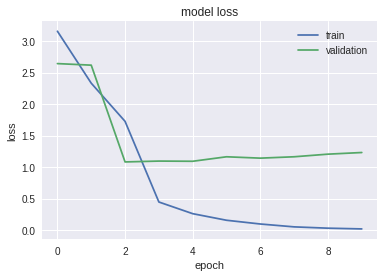

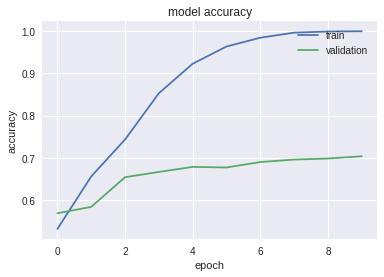

In [0]:
plotLosses(history)
plotAcc(history)

### Model 2 (Increase epochs)

In [0]:
epochs = 50
batch_size = 256
lr = 0.0001

In [0]:
model.compile(Adam(lr = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
history = model.fit(x_train, 
                    y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    verbose = 1,
                    validation_data = (x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 24s 484us/step - loss: 3.6863 - acc: 0.5344 - val_loss: 2.3128 - val_acc: 0.5933
Epoch 2/50
50000/50000 [==============================] - 23s 460us/step - loss: 0.8957 - acc: 0.7060 - val_loss: 1.0262 - val_acc: 0.6610
Epoch 3/50
50000/50000 [==============================] - 23s 462us/step - loss: 0.5600 - acc: 0.8079 - val_loss: 1.0304 - val_acc: 0.6673
Epoch 4/50
50000/50000 [==============================] - 23s 460us/step - loss: 0.3603 - acc: 0.8870 - val_loss: 1.0622 - val_acc: 0.6724
Epoch 5/50
50000/50000 [==============================] - 23s 460us/step - loss: 0.2229 - acc: 0.9405 - val_loss: 1.0896 - val_acc: 0.6814
Epoch 6/50
50000/50000 [==============================] - 23s 462us/step - loss: 0.1364 - acc: 0.9723 - val_loss: 1.1351 - val_acc: 0.6821
Epoch 7/50
50000/50000 [==============================] - 23s 460us/step - loss: 0.0838 - acc: 0.9888 - val_loss: 1.

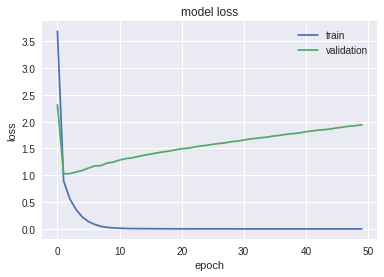

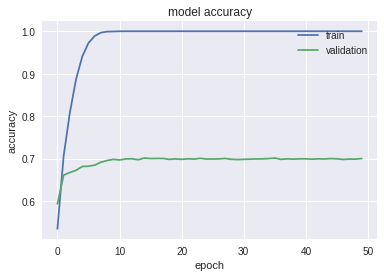

In [0]:
plotLosses(history)
plotAcc(history)

### Model 3 (Decrease Learning Rate)

In [0]:
epochs = 50
batch_size = 256


In [0]:
model.compile(Adam(lr = 1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
history = model.fit(x_train, 
                    y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    verbose = 1,
                    validation_data = (x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 27s 543us/step - loss: 2.9902 - acc: 0.2747 - val_loss: 2.2024 - val_acc: 0.4000
Epoch 2/50
50000/50000 [==============================] - 22s 443us/step - loss: 1.9483 - acc: 0.4422 - val_loss: 1.8170 - val_acc: 0.4764
Epoch 3/50
50000/50000 [==============================] - 22s 444us/step - loss: 1.6605 - acc: 0.5037 - val_loss: 1.6460 - val_acc: 0.5148
Epoch 4/50
50000/50000 [==============================] - 22s 445us/step - loss: 1.5039 - acc: 0.5389 - val_loss: 1.5471 - val_acc: 0.5342
Epoch 5/50
50000/50000 [==============================] - 22s 445us/step - loss: 1.3989 - acc: 0.5629 - val_loss: 1.4774 - val_acc: 0.5491
Epoch 6/50
50000/50000 [==============================] - 22s 446us/step - loss: 1.3207 - acc: 0.5829 - val_loss: 1.4280 - val_acc: 0.5603
Epoch 7/50
50000/50000 [==============================] - 22s 446us/

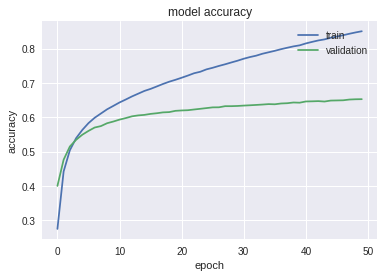

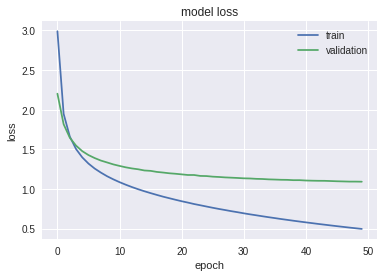

In [0]:
plotAcc(history)
plotLosses(history)

## Results

In [0]:
acc_arr = {'model 1':0.7034,'model 2':0.7001,'model 3':0.6528}

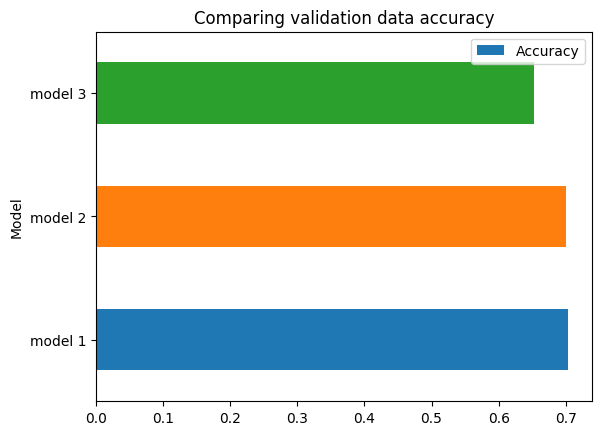

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(list(acc_arr.items()), columns=['Model', 'Accuracy'])
ax = df.plot.barh(x='Model', y='Accuracy',title = "Comparing validation data accuracy",legend = 'false')

We may conclude that model 1 performed the best.


### Possible reasons for below average performance?

* VGG16 was trained on 224x224x3 images but we are trying to classify 32x32 images.
* Speed of learning too high

## References

https://towardsdatascience.com/transfer-learning-946518f95666

https://keras.io/applications/#vgg16